In [8]:
import tensorflow as tf
import numpy as np

## Loading data

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen = ImageDataGenerator(rescale=1.0/255)

In [10]:
# directory
imgdir = 'a5_images'
img_size = 64
batch_size = 32

train_generator = data_gen.flow_from_directory(
        imgdir + '/train',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        classes=['other', 'car'],
        seed=12345,
        shuffle=True)

Found 1600 images belonging to 2 classes.


In [11]:
Xbatch, Ybatch = train_generator.next()

In [12]:
Xbatch.shape

(32, 64, 64, 3)

In [13]:
Ybatch[4]

1.0

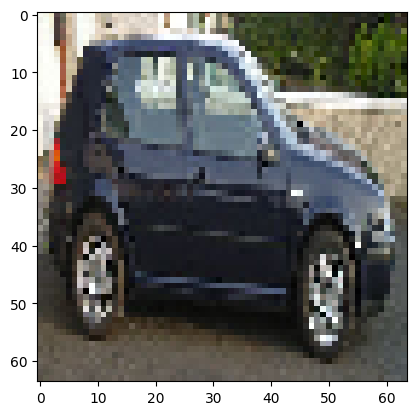

In [14]:
from matplotlib import pyplot as plt

plt.imshow(Xbatch[4]);

## Part 1: Training a convolutional neural network

## Part 2: Data augmentation

## Applying a pre-trained convolutional neural network

In [15]:
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import decode_predictions, preprocess_input

vggmodel = applications.VGG16(weights='imagenet', include_top=True)

553467096/553467096 [==============================] - 49s 0us/step


## Part 3: Using VGG-16 as a feature extractor

In [16]:
feature_extractor = applications.VGG16(include_top=False, weights='imagenet',
                                       input_shape=(img_size, img_size, 3))

58889256/58889256 [==============================] - 5s 0us/step


In [ ]:
vgg_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
def create_vgg16_features():

In [17]:
def get_labels(n):
    return np.array([0]*(n//2) + [1]*(n//2))

## Part 4: Visualizing the learned features

In [18]:
first_layer_weights = vggmodel.get_weights()[0]
first_layer_weights.shape

(3, 3, 3, 64)

In [19]:
def kernel_image(weights, i, positive):

    # extract the convolutional kernel at position i
    k = weights[:,:,:,i].copy()
    if not positive:
        k = -k

    # clip the values: if we're looking for positive
    # values, just keep the positive part; vice versa
    # for the negative values.
    k *= k > 0

    # rescale the colors, to make the images less dark
    m = k.max()
    if m > 1e-3:
        k /= m

    return k

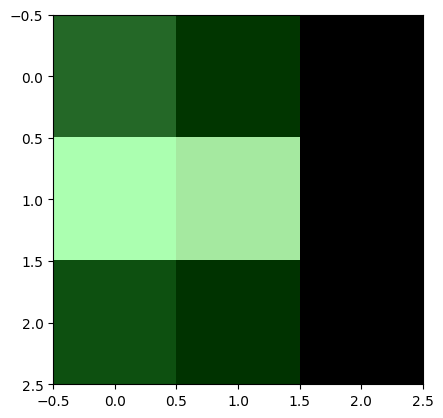

In [31]:
plt.imshow(kernel_image(first_layer_weights, 0, True))
plt.imshow(kernel_image(first_layer_weights, 1, True))
plt.imshow(kernel_image(first_layer_weights, 2, True))
